In [ ]:
## load some packages
import matplotlib.pyplot as plt
from scipy.special import erf
import pandas as pd
import numpy as np
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import normalize
import seaborn as sns

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
data_dir = "crocker_results_new"
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".npy")])
vectorized_data = []

for fname in file_list:
    matrix = np.load(os.path.join(data_dir, fname))
    vector = matrix.flatten()
    
    # Normalize the vector using L2 norm
    norm_vector = normalize(vector.reshape(1, -1), norm='l2')[0]
    vectorized_data.append(norm_vector)

X = np.vstack(vectorized_data)
print("Shape of X:", X.shape)

In [2]:
# persitance image
def stacked_guassian_cdf(x, mu, sigma, thresh=100_000_000):
    '''
    Integrates arbitrarily many 1-dimensional gaussians between `x` values. Each
    gaussian should have a mean in the array mu and the same standard deviation
    sigma.
    '''
    if x.size * mu.size <= thresh:  # create large, in memory matrix #Change thresh to be lower!! 
        cdfvals = erf((x - mu[..., None]) / sigma / np.sqrt(2)) / 2
        # 0.5 + cdfvals is the cdf of the gaussian at x (column) for gaussian mu (row)
        return (cdfvals[..., 1:] - cdfvals[..., :-1])
    else:  # evaluate 1 at a time
        eval_bounds = lambda x: x[1:] - x[:-1]
        return np.array([eval_bounds(erf((x - m[..., None]) / sigma / np.sqrt(2))) for m in  mu.flatten()]) / 2
    

def sum_bigaussians(x_cells, y_cells, weights, thresh=100_000_000):
    '''
    Weights, multuplies to make bivariate, and sums gaussians
    '''
    if x_cells.size * y_cells.shape[-1] <= thresh:  # create large, in memory matrix
        return (weights[..., None] * x_cells * y_cells[None, ...].T).sum(axis=tuple(range(1, weights.ndim + 1)))
    else:
        return np.sum([w * x_cells[i] * y_cells[i][:, None] for i, w in np.ndenumerate(weights)], axis=0)


def persistance_image(barcode, resolution=20, sigma=0.1, weight_func=lambda b, p: p): #Change resolution to 10, and infinite to 100 
    '''
    Makes a persistance image for a barcode

    `barcode` should be an N by 2 matrix of a single dimension's birth-death
    pairs. The first column should be birth times and the second should be
    death times. The death column *can* contain infs.

    Assumes finite birth and death are in [0, 1].
    '''
    # turn barcode into a useable form
    barcode = np.array(barcode)

    # x and y bounds
    x = np.linspace(0, 1, resolution + 1)  # add 1 so there are resolution spaces between x values
    y = np.linspace(0, 1, resolution + 1)

    # finite lifetime parts
    finite_bc = barcode[barcode[:, 1] < np.inf]
    weights = weight_func(finite_bc[:, 0], finite_bc[:, 1] - finite_bc[:, 0])
    birth_cells = stacked_guassian_cdf(x, finite_bc[:, 0], sigma=sigma)
    death_cells = stacked_guassian_cdf(y, finite_bc[:, 1] - finite_bc[:, 0], sigma=sigma)
    finite_pi = sum_bigaussians(birth_cells, death_cells, weights, thresh=10)

    # infinite lifetime parts
    infinite_bc = barcode[barcode[:, 1] == np.inf]
    weights = weight_func(infinite_bc[:, 0], 1 - infinite_bc[:, 0])
    # print(weights)
    birth_cells = stacked_guassian_cdf(x, infinite_bc[:, 0], sigma=sigma)
    infinite_pi = (weights[:, None] * birth_cells).sum(axis=tuple(range(birth_cells.ndim - 1)))

    return finite_pi, infinite_pi

In [ ]:
#Read in the barcodes file that has the topological information for all fields 
barcodes = pd.read_pickle('https://www.dropbox.com/scl/fi/ghrxrihln2bxgw0u9hxp5/all_barcodes.pkl?rlkey=hqaklrvmn9snc3pmxpjq2gdwi&st=6jjs4zy7&dl=1')

barcodes['field'] = barcodes['field'].str.strip() #There are spaces after some field names

barcodes

,dimension,birth,death,birth simplex,death simplex,field,code
0,0,0.970297,0.980198,[3626],"[493, 3626]",Accounting_Auditing_Accountability,1501
1,0,0.970297,0.980198,[2220],"[1714, 2220]",Accounting_Auditing_Accountability,1501
2,0,0.970297,0.980198,[170],"[112, 170]",Accounting_Auditing_Accountability,1501
3,0,0.960396,0.980198,[4010],"[216, 4010]",Accounting_Auditing_Accountability,1501
4,0,0.960396,0.980198,[3837],"[1874, 3837]",Accounting_Auditing_Accountability,1501
...,...,...,...,...,...,...,...
6831540,3,0.960396,1.000000,"[1051, 1222, 1243, 1555]","[614, 1051, 1222, 1555, 2019]",Zoology,608
6831541,3,0.960396,inf,"[437, 447, 1174, 1243]",None,Zoology,608
6831542,3,0.960396,0.990099,"[437, 447, 1174, 1222]","[1025, 1066, 1174, 1558, 1730]",Zoology,608
6831543,3,0.960396,0.990099,"[271, 273, 666, 1051]","[273, 279, 666, 871, 1051]",Zoology,608


In [4]:
#Config: 
sigma = 0.1 
resolution = 20 

In [ ]:
#Impute all inf deaths with 1 
max_value = 1
impute = barcodes.copy()
impute.loc[impute['death'] == np.inf, 'death'] = max_value
impute

,dimension,birth,death,birth simplex,death simplex,field,code
0,0,0.970297,0.980198,[3626],"[493, 3626]",Accounting_Auditing_Accountability,1501
1,0,0.970297,0.980198,[2220],"[1714, 2220]",Accounting_Auditing_Accountability,1501
2,0,0.970297,0.980198,[170],"[112, 170]",Accounting_Auditing_Accountability,1501
3,0,0.960396,0.980198,[4010],"[216, 4010]",Accounting_Auditing_Accountability,1501
4,0,0.960396,0.980198,[3837],"[1874, 3837]",Accounting_Auditing_Accountability,1501
...,...,...,...,...,...,...,...
6831540,3,0.960396,1.000000,"[1051, 1222, 1243, 1555]","[614, 1051, 1222, 1555, 2019]",Zoology,608
6831541,3,0.960396,1.000000,"[437, 447, 1174, 1243]",None,Zoology,608
6831542,3,0.960396,0.990099,"[437, 447, 1174, 1222]","[1025, 1066, 1174, 1558, 1730]",Zoology,608
6831543,3,0.960396,0.990099,"[271, 273, 666, 1051]","[273, 279, 666, 871, 1051]",Zoology,608


### Different normalizing methods: 

In [22]:
#Normalize by field, by dimension, and separate the metric spaces

def sep_dim(barcodes, k=6):
    ''' Separate into two metric spaces for finite and infinite features and normalized by the number 
    of total features by dimension by field, then find the persistence images for 
    dimensions 0 - 5 (finite and then infinite), and then concatenate them into a vector'''
    df_norm = pd.DataFrame() #Initialize a df 

    for field in barcodes['field'].unique(): #Do this for all 133 fields in the barcodes df 

        all_finite_norm  = [] #Make a list of finite features (features that die)
        all_infinite_norm  = [] #Make a list of inifinite features (features that don't die)
        field_barcode = barcodes[barcodes['field']==field] #Restrict the output to only having values from one field at a time 
        
        for dim in range(0, k): #For all dimensions (we have 0 to 5)
            dim_bc = field_barcode[field_barcode['dimension'] == dim] #Restrict this to being one dimension at a time 
            number = len(dim_bc)
            finite_pi, infinite_pi = persistance_image(
                dim_bc.loc[dim_bc['dimension'] == dim, ['birth', 'death']],  # can add .values and call on numpy array too
                resolution=resolution,
                sigma=sigma
            )

            finite_pi = finite_pi / number 
            infinite_pi = infinite_pi / number 

            all_finite_norm.append(finite_pi) #Add finite dimension dim features to the list 
            all_infinite_norm .append(infinite_pi) #Add infinite dimension dim features to the list 

        all_norm  = all_finite_norm + all_infinite_norm  #Make a new list with both (so the order is 0-5 dim finite and then 0-5 dim infinite)
        vector = np.concatenate([arr.flatten() for arr in all_norm ]) #Add these vectors together 
        df_norm [field] = vector #Label each vector with their corresponding field 

    df_norm  = df_norm .T #Transpose to get the fields to be indexes

    matrix_norm  = df_norm .values # Get all the values from the df in a numpy array 

    matrix_norm = np.nan_to_num(matrix_norm, nan=0.0) #Fill in nans with 0s 

    return df_norm, matrix_norm

In [ ]:
# Normalized by field by dimension, imputing values 

def imp_dim(impute, k=6): 
    ''' Impute 1 into all infinite features' deaths, and then find the persistence 
    images for dimensions 0 - 5, and concatenate them into a vector, normalized by field by dimension'''
    #Impute all inf deaths with 1 
    max_value = 1
    impute = barcodes.copy()
    impute.loc[impute['death'] == np.inf, 'death'] = max_value

    df_norm_imp = pd.DataFrame() #Initialize a df 

    for field in impute['field'].unique(): #Do this for all 133 fields in the barcodes df 

        all_norm_imp  = [] 
        field_barcode = impute[impute['field']==field] #Restrict the output to only having values from one field at a time 
        
        for dim in range(0, k): #For all dimensions (we have 0 to 5)
            dim_bc = field_barcode[field_barcode['dimension'] == dim] #Restrict this to being one dimension at a time 
            number = len(dim_bc)
            finite_pi, _ = persistance_image(
                dim_bc.loc[dim_bc['dimension'] == dim, ['birth', 'death']],  # can add .values and call on numpy array too
                resolution=resolution,
                sigma=sigma
            )

            finite_pi = finite_pi / number 

            all_norm_imp.append(finite_pi) #Add finite dimension dim features to the list 

        vector = np.concatenate([arr.flatten() for arr in all_norm_imp ]) #Add these vectors together 
        df_norm_imp [field] = vector #Label each vector with their corresponding field 

    df_norm_imp  = df_norm_imp.T #Transpose to get the fields to be indexes

    matrix_norm_imp  = df_norm_imp.values # Get all the values from the df in a numpy array 

    matrix_norm_imp = np.nan_to_num(matrix_norm_imp, nan=0.0)

    return df_norm_imp, matrix_norm_imp
    

In [24]:
#Separated metric spaces, normalized by number of field features

def sep_field (barcodes, k=6):
    ''' Separate into two metric spaces for finite and infinite features and normalized by the number 
    of total features by field, then find the persistence images for 
    dimensions 0 - 5 (finite and then infinite), and then concatenate them into a vector'''
    df_norm_field = pd.DataFrame()

    # each field a column in dataframe
    for field in barcodes['field'].unique():
        # df[field] = field
        all_finite = []
        all_infinite = []
        field_barcode = barcodes[barcodes['field']== field]
        size_features = len(field_barcode)
        
        for dim in range(0 , k): 
            dim_bc = field_barcode[field_barcode['dimension'] == dim]
            finite_pi, infinite_pi = persistance_image(
                dim_bc.loc[dim_bc['dimension'] == dim, ['birth', 'death']],  # can add .values and call on numpy array too
                resolution=resolution,
                sigma=sigma 
            )

            
            # Normalizing the PI by num of features
            finite_pi = finite_pi / size_features
            infinite_pi = infinite_pi / size_features

            all_finite.append(finite_pi)
            all_infinite.append(infinite_pi)

        all = all_finite + all_infinite
        vector = np.concatenate([arr.flatten() for arr in all])
        df_norm_field[field] = vector

    df_norm_field  = df_norm_field.T #Transpose to get the fields to be indexes

    matrix_norm_field  = df_norm_field.values # Get all the values from the df in a numpy array 

    matrix_norm_field = np.nan_to_num(matrix_norm_field, nan=0.0)

    return df_norm_field, matrix_norm_field

In [29]:
def imp_field (impute, k = 6):
    ''' Impute 1 into all infinite features' deaths, and then find the persistence 
    images for dimensions 0 - 5, and concatenate them into a vector, normalized by field'''
    df_impute = pd.DataFrame()

    # each field a column in dataframe
    for field in impute['field'].unique():
        all_finite = []
        all_infinite = []
        field_barcode = impute[impute['field']== field]
        
        for dim in range(0, k): 
            dim_bc = field_barcode[field_barcode['dimension'] == dim]


            finite_pi, infinite_pi = persistance_image(
                dim_bc.loc[dim_bc['dimension'] == dim, ['birth', 'death']],  # can add .values and call on numpy array too
                resolution=resolution,
                sigma=sigma 
            )

            all_finite.append(finite_pi)
            all_infinite.append(infinite_pi)

        all = all_finite + all_infinite
        vector = np.concatenate([arr.flatten() for arr in all])
        df_impute[field] = vector

    df_impute  = df_impute.T #Transpose to get the fields to be indexes

    matrix_impute  = df_impute.values # Get all the values from the df in a numpy array 

    matrix_impute = np.nan_to_num(matrix_impute, nan=0.0)

    return df_impute, matrix_impute

    

### Clustering functions

In [26]:
# function to get the cluster+label
def get_cluster_labels(matrix, df, method, n_clusters=3, linkage='ward'):
    if method == 'h':
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    elif method == 'k':
        model = KMedoids(n_clusters=n_clusters, random_state=42)
    # assign labels
    labels = model.fit(matrix).labels_

    # attatch cluster labels to a copy of df
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels

    return labels, df_with_clusters

In [27]:
def dendo(matrix, df):
    linked = linkage(matrix, method='ward') 
    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=df.index.tolist(), 
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title('Dendrogram')
    plt.xlabel('Data Points')
    plt.ylabel('Euclidean Distance')
    plt.show()

### ARI Heatmap

In [30]:
#Imputed by field normalized
df_imp_f0, mat_imp_f0 = imp_field(impute, k=1)
df_imp_f1, mat_imp_f1 = imp_field(impute, k=2)
df_imp_f2, mat_imp_f2 = imp_field(impute, k=3)
df_imp_f3, mat_imp_f3 = imp_field(impute, k=4)
df_imp_f4, mat_imp_f4 = imp_field(impute, k=5)
df_imp_f5, mat_imp_f5 = imp_field(impute, k=6)

#Imputed by dimension normalized 
df_imp_d0, mat_imp_d0 = imp_dim(impute, k=1)
df_imp_d1, mat_imp_d1 = imp_dim(impute, k=2)
df_imp_d2, mat_imp_d2 = imp_dim(impute, k=3)
df_imp_d3, mat_imp_d3 = imp_dim(impute, k=4)
df_imp_d4, mat_imp_d4 = imp_dim(impute, k=5)
df_imp_d5, mat_imp_d5 = imp_dim(impute, k=6)

#Separated by dimension normalized 
df_sep_d0, mat_sep_d0 = sep_field(barcodes, k=1)
df_sep_d1, mat_sep_d1 = sep_field(barcodes, k=2)
df_sep_d2, mat_sep_d2 = sep_field(barcodes, k=3)
df_sep_d3, mat_sep_d3 = sep_field(barcodes, k=4)
df_sep_d4, mat_sep_d4 = sep_field(barcodes, k=5)
df_sep_d5, mat_sep_d5 = sep_field(barcodes, k=6)

#Separated by field normalized
df_sep_d0, mat_sep_d0 = sep_dim(barcodes, k=1)
df_sep_d1, mat_sep_d1 = sep_dim(barcodes, k=2)
df_sep_d2, mat_sep_d2 = sep_dim(barcodes, k=3)
df_sep_d3, mat_sep_d3 = sep_dim(barcodes, k=4)
df_sep_d4, mat_sep_d4 = sep_dim(barcodes, k=5)
df_sep_d5, mat_sep_d5 = sep_dim(barcodes, k=6)

/var/folders/_4/2x1njcf17rb3bgly4tps55c80000gn/T/ipykernel_1186/2264589424.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_impute[field] = vector
/var/folders/_4/2x1njcf17rb3bgly4tps55c80000gn/T/ipykernel_1186/2264589424.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_impute[field] = vector
/var/folders/_4/2x1njcf17rb3bgly4tps55c80000gn/T/ipykernel_1186/2264589424.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [31]:
# imputed by field normalized 
#hierarchical
hlabels_imp_f0, hdf_clust_imp_f0 = get_cluster_labels(mat_imp_f0, df_imp_f0, method='h', n_clusters=3)
hlabels_imp_f1, hdf_clust_imp_f1 = get_cluster_labels(mat_imp_f1, df_imp_f1, method='h', n_clusters=3)
hlabels_imp_f2, hdf_clust_imp_f2 = get_cluster_labels(mat_imp_f2, df_imp_f2, method='h', n_clusters=3)
hlabels_imp_f3, hdf_clust_imp_f3 = get_cluster_labels(mat_imp_f3, df_imp_f3, method='h', n_clusters=3)
hlabels_imp_f4, hdf_clust_imp_f4 = get_cluster_labels(mat_imp_f4, df_imp_f4, method='h', n_clusters=3)
hlabels_imp_f5, hdf_clust_imp_f5 = get_cluster_labels(mat_imp_f5, df_imp_f5, method='h', n_clusters=3)

#kmediods
klabels_imp_f0, kdf_clust_imp_f0 = get_cluster_labels(mat_imp_f0, df_imp_f0, method='k', n_clusters=3)
klabels_imp_f1, kdf_clust_imp_f1 = get_cluster_labels(mat_imp_f1, df_imp_f1, method='k', n_clusters=3)
klabels_imp_f2, kdf_clust_imp_f2 = get_cluster_labels(mat_imp_f2, df_imp_f2, method='k', n_clusters=3)
klabels_imp_f3, kdf_clust_imp_f3 = get_cluster_labels(mat_imp_f3, df_imp_f3, method='k', n_clusters=3)
klabels_imp_f4, kdf_clust_imp_f4 = get_cluster_labels(mat_imp_f4, df_imp_f4, method='k', n_clusters=3)
klabels_imp_f5, kdf_clust_imp_f5 = get_cluster_labels(mat_imp_f5, df_imp_f5, method='k', n_clusters=3)

# imputed by dim, normalized 
#heirarchical
hlabels_imp_d0, hdf_clust_imp_d0 = get_cluster_labels(mat_imp_d0, df_imp_d0, method='h', n_clusters=3)
hlabels_imp_d1, hdf_clust_imp_d1 = get_cluster_labels(mat_imp_d1, df_imp_d1, method='h', n_clusters=3)
hlabels_imp_d2, hdf_clust_imp_d2 = get_cluster_labels(mat_imp_d2, df_imp_d2, method='h', n_clusters=3)
hlabels_imp_d3, hdf_clust_imp_d3 = get_cluster_labels(mat_imp_d3, df_imp_d3, method='h', n_clusters=3)
hlabels_imp_d4, hdf_clust_imp_d4 = get_cluster_labels(mat_imp_d4, df_imp_d4, method='h', n_clusters=3)
hlabels_imp_d5, hdf_clust_imp_d5 = get_cluster_labels(mat_imp_d5, df_imp_d5, method='h', n_clusters=3)

#kmediods
klabels_imp_d0, kdf_clust_imp_d0 = get_cluster_labels(mat_imp_d0, df_imp_d0, method='k', n_clusters=3)
klabels_imp_d1, kdf_clust_imp_d1 = get_cluster_labels(mat_imp_d1, df_imp_d1, method='k', n_clusters=3)
klabels_imp_d2, kdf_clust_imp_d2 = get_cluster_labels(mat_imp_d2, df_imp_d2, method='k', n_clusters=3)
klabels_imp_d3, kdf_clust_imp_d3 = get_cluster_labels(mat_imp_d3, df_imp_d3, method='k', n_clusters=3)
klabels_imp_d4, kdf_clust_imp_d4 = get_cluster_labels(mat_imp_d4, df_imp_d4, method='k', n_clusters=3)
klabels_imp_d5, kdf_clust_imp_d5 = get_cluster_labels(mat_imp_d5, df_imp_d5, method='k', n_clusters=3)

# seperated by dim, normalized
#hierarchical
hlabels_sep_d0, hdf_clust_sep_d0 = get_cluster_labels(mat_sep_d0, df_sep_d0, method='h', n_clusters=3)
hlabels_sep_d1, hdf_clust_sep_d1 = get_cluster_labels(mat_sep_d1, df_sep_d1, method='h', n_clusters=3)
hlabels_sep_d2, hdf_clust_sep_d2 = get_cluster_labels(mat_sep_d2, df_sep_d2, method='h', n_clusters=3)
hlabels_sep_d3, hdf_clust_sep_d3 = get_cluster_labels(mat_sep_d3, df_sep_d3, method='h', n_clusters=3)
hlabels_sep_d4, hdf_clust_sep_d4 = get_cluster_labels(mat_sep_d4, df_sep_d4, method='h', n_clusters=3)
hlabels_sep_d5, hdf_clust_sep_d5 = get_cluster_labels(mat_sep_d5, df_sep_d5, method='h', n_clusters=3)

#kmediods
klabels_sep_d0, kdf_clust_sep_d0 = get_cluster_labels(mat_sep_d0, df_sep_d0, method='k', n_clusters=3)
klabels_sep_d1, kdf_clust_sep_d1 = get_cluster_labels(mat_sep_d1, df_sep_d1, method='k', n_clusters=3)
klabels_sep_d2, kdf_clust_sep_d2 = get_cluster_labels(mat_sep_d2, df_sep_d2, method='k', n_clusters=3)
klabels_sep_d3, kdf_clust_sep_d3 = get_cluster_labels(mat_sep_d3, df_sep_d3, method='k', n_clusters=3)
klabels_sep_d4, kdf_clust_sep_d4 = get_cluster_labels(mat_sep_d4, df_sep_d4, method='k', n_clusters=3)
klabels_sep_d5, kdf_clust_sep_d5 = get_cluster_labels(mat_sep_d5, df_sep_d5, method='k', n_clusters=3)

# seperated by field, normalized
#heirarchical
hlabels_sep_f0, hdf_clust_sep_f0 = get_cluster_labels(mat_sep_d0, df_sep_d0, method='h', n_clusters=3)
hlabels_sep_f1, hdf_clust_sep_f1 = get_cluster_labels(mat_sep_d1, df_sep_d1, method='h', n_clusters=3)
hlabels_sep_f2, hdf_clust_sep_f2 = get_cluster_labels(mat_sep_d2, df_sep_d2, method='h', n_clusters=3)
hlabels_sep_f3, hdf_clust_sep_f3 = get_cluster_labels(mat_sep_d3, df_sep_d3, method='h', n_clusters=3)
hlabels_sep_f4, hdf_clust_sep_f4 = get_cluster_labels(mat_sep_d4, df_sep_d4, method='h', n_clusters=3)
hlabels_sep_f5, hdf_clust_sep_f5 = get_cluster_labels(mat_sep_d5, df_sep_d5, method='h', n_clusters=3)

#kmediods
klabels_sep_f0, kdf_clust_sep_f0 = get_cluster_labels(mat_sep_d0, df_sep_d0, method='k', n_clusters=3)
klabels_sep_f1, kdf_clust_sep_f1 = get_cluster_labels(mat_sep_d1, df_sep_d1, method='k', n_clusters=3)
klabels_sep_f2, kdf_clust_sep_f2 = get_cluster_labels(mat_sep_d2, df_sep_d2, method='k', n_clusters=3)
klabels_sep_f3, kdf_clust_sep_f3 = get_cluster_labels(mat_sep_d3, df_sep_d3, method='k', n_clusters=3)
klabels_sep_f4, kdf_clust_sep_f4 = get_cluster_labels(mat_sep_d4, df_sep_d4, method='k', n_clusters=3)
klabels_sep_f5, kdf_clust_sep_f5 = get_cluster_labels(mat_sep_d5, df_sep_d5, method='k', n_clusters=3)

In [35]:
labels = [hlabels_imp_f0, hlabels_imp_f1, hlabels_imp_f2, hlabels_imp_f3, hlabels_imp_f4, hlabels_imp_f5, 
        hlabels_imp_d0, hlabels_imp_d1, hlabels_imp_d2, hlabels_imp_d3, hlabels_imp_d4, hlabels_imp_d5, 
        hlabels_sep_f0, hlabels_sep_f1, hlabels_sep_f2, hlabels_sep_f3, hlabels_sep_f4, hlabels_sep_f5,
        hlabels_sep_d0, hlabels_sep_d1, hlabels_sep_d2, hlabels_sep_d3, hlabels_sep_d4, hlabels_sep_d5, 
        klabels_imp_f0, klabels_imp_f1, klabels_imp_f2, klabels_imp_f3, klabels_imp_f4, klabels_imp_f5, 
        klabels_imp_d0, klabels_imp_d1, klabels_imp_d2, klabels_imp_d3, klabels_imp_d4, klabels_imp_d5, 
        klabels_sep_f0, klabels_sep_f1, klabels_sep_f2, klabels_sep_f3, klabels_sep_f4, klabels_sep_f5,
        klabels_sep_d0, klabels_sep_d1, klabels_sep_d2, klabels_sep_d3, klabels_sep_d4, klabels_sep_d5
        ]

label_names = [
    'hlabels_imp_f0', 'hlabels_imp_f1', 'hlabels_imp_f2', 'hlabels_imp_f3', 'hlabels_imp_f4', 'hlabels_imp_f5',
    'hlabels_imp_d0', 'hlabels_imp_d1', 'hlabels_imp_d2', 'hlabels_imp_d3', 'hlabels_imp_d4', 'hlabels_imp_d5',
    'hlabels_sep_f0', 'hlabels_sep_f1', 'hlabels_sep_f2', 'hlabels_sep_f3', 'hlabels_sep_f4', 'hlabels_sep_f5',
    'hlabels_sep_d0', 'hlabels_sep_d1', 'hlabels_sep_d2', 'hlabels_sep_d3', 'hlabels_sep_d4', 'hlabels_sep_d5',
    'klabels_imp_f0', 'klabels_imp_f1', 'klabels_imp_f2', 'klabels_imp_f3', 'klabels_imp_f4', 'klabels_imp_f5',
    'klabels_imp_d0', 'klabels_imp_d1', 'klabels_imp_d2', 'klabels_imp_d3', 'klabels_imp_d4', 'klabels_imp_d5',
    'klabels_sep_f0', 'klabels_sep_f1', 'klabels_sep_f2', 'klabels_sep_f3', 'klabels_sep_f4', 'klabels_sep_f5',
    'klabels_sep_d0', 'klabels_sep_d1', 'klabels_sep_d2', 'klabels_sep_d3', 'klabels_sep_d4', 'klabels_sep_d5'
]


# Initialize matrix
n = len(labels)
ari_matrix = np.zeros((n, n))

# Compute pairwise ARIs
for i in range(n):
    for j in range(n):
        ari_matrix[i, j] = adjusted_rand_score(labels[i], labels[j])

# Convert to DataFrame for easier labeling
ari_df = pd.DataFrame(ari_matrix, index=label_names, columns=label_names)



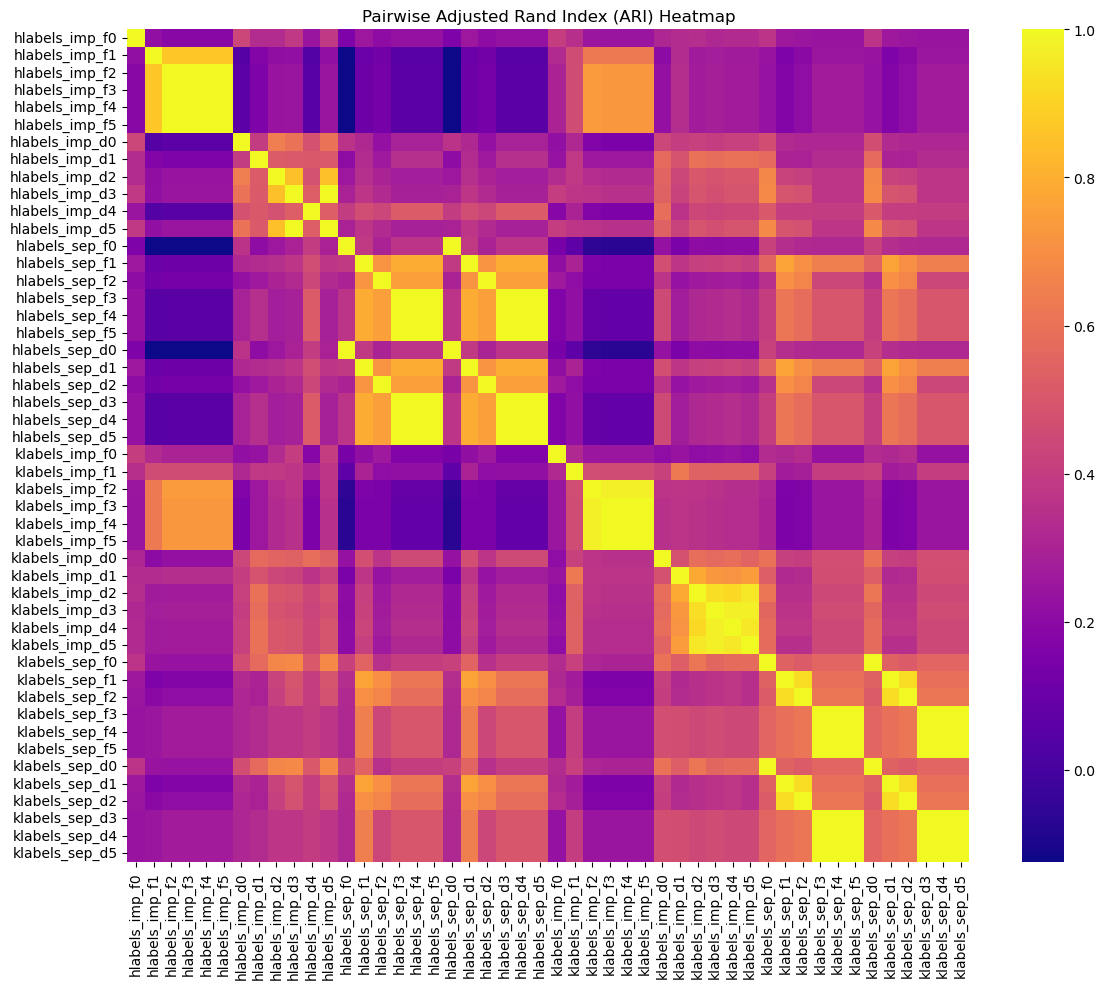

In [ ]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ari_df, cmap="plasma", annot=False, xticklabels=True, yticklabels=True)
plt.title("Pairwise Adjusted Rand Index (ARI) Heatmap")
plt.tight_layout()
plt.show()

In [37]:
labels = [hlabels_imp_f3, hlabels_imp_f4, hlabels_imp_f5, 
        klabels_imp_f3, klabels_imp_f4, klabels_imp_f5, 
         hlabels_imp_d3, hlabels_imp_d4, hlabels_imp_d5, 
        klabels_imp_d3, klabels_imp_d4, klabels_imp_d5, 
        hlabels_sep_f3, hlabels_sep_f4, hlabels_sep_f5,
        klabels_sep_f3, klabels_sep_f4, klabels_sep_f5,
        hlabels_sep_d3, hlabels_sep_d4, hlabels_sep_d5, 
        klabels_sep_d3, klabels_sep_d4, klabels_sep_d5
        ]

label_names = [
    'hlabels_imp_f3', 'hlabels_imp_f4', 'hlabels_imp_f5', 
    'klabels_imp_f3', 'klabels_imp_f4', 'klabels_imp_f5', 
    'hlabels_imp_d3', 'hlabels_imp_d4', 'hlabels_imp_d5', 
    'klabels_imp_d3', 'klabels_imp_d4', 'klabels_imp_d5', 
    'hlabels_sep_f3', 'hlabels_sep_f4', 'hlabels_sep_f5',
    'klabels_sep_f3', 'klabels_sep_f4', 'klabels_sep_f5',
    'hlabels_sep_d3', 'hlabels_sep_d4', 'hlabels_sep_d5', 
    'klabels_sep_d3', 'klabels_sep_d4', 'klabels_sep_d5'
]


# Initialize matrix
n = len(labels)
ari_matrix = np.zeros((n, n))

# Compute pairwise ARIs
for i in range(n):
    for j in range(n):
        ari_matrix[i, j] = adjusted_rand_score(labels[i], labels[j])

# Convert to DataFrame for easier labeling
ari_df = pd.DataFrame(ari_matrix, index=label_names, columns=label_names)

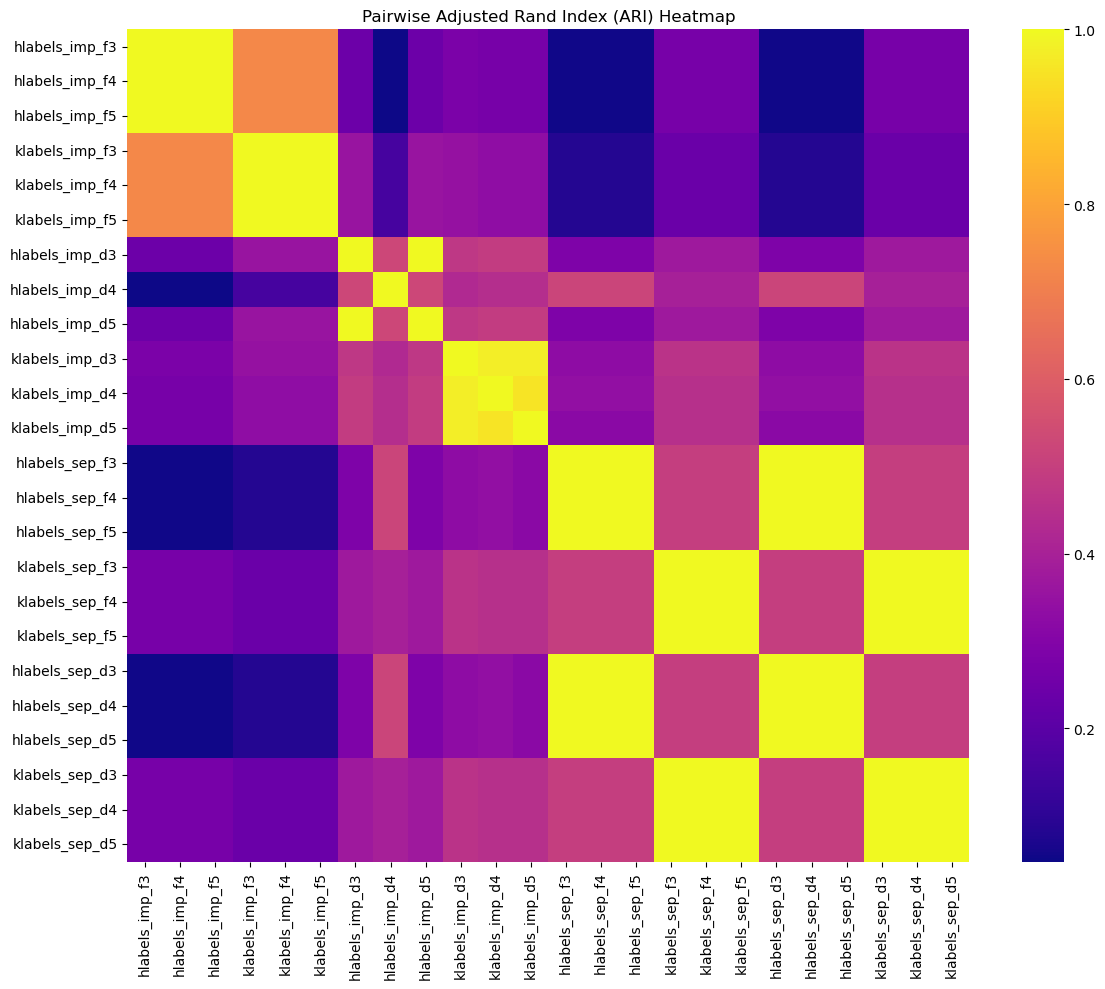

In [41]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ari_df, cmap="plasma", annot=False, xticklabels=True, yticklabels=True)
plt.title("Pairwise Adjusted Rand Index (ARI) Heatmap")
plt.tight_layout()
plt.show()

In [52]:
era = pd.read_csv('/Users/tanisha/Desktop/Summer/Era.csv')
era['field'] = era['field'].str.strip()
era

,Unnamed: 0,code,field,spec,area
0,0,1501,Accounting_Auditing_Accountability,"Commerce, Management, Tourism and Services",Economics and Commerce
1,1,901,Aerospace_Engineering,Engineering,Engineering and Environmental Sciences
2,2,1001,Agricultural_Biotechnology,Technology,Biological and Biotechnological Sciences
3,3,701,Agriculture_Land_Farm_Management,Agricultural and Veterinary Sciences,Biological and Biotechnological Sciences
4,4,301,Analytical_Chemistry,Chemical Sciences,"Physical, Chemical and Earth Sciences"
...,...,...,...,...,...
149,149,1507,Transportation_Freight_Services,"Commerce, Management, Tourism and Services",Economics and Commerce
150,150,1205,Urban_Regional_Planning,Built Environment and Design,Humanities and Creative Arts
151,151,707,Veterinary_Sciences,Agricultural and Veterinary Sciences,Biological and Biotechnological Sciences
152,152,1905,Visual_Arts_Crafts,Studies in Creative Arts and Writing,Humanities and Creative Arts


In [53]:
kdf_clust_sep_d5_e = kdf_clust_sep_d5.reset_index()
kdf_clust_sep_d5_e.rename(columns={'index': 'field'}, inplace=True)
df_merged = pd.merge(kdf_clust_sep_d5_e, era, on='field', how='left')
df_merged = df_merged.set_index('field')


In [77]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Your input data
X = mat_sep_d5 
y_str = df_merged['area']  # Labels as strings

# Encode string labels as integers
le = LabelEncoder()
y = le.fit_transform(y_str)

# Create a t-SNE object
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Apply t-SNE
X_tsne = tsne.fit_transform(X)  

# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='Spectral', s=10)
plt.title("t-SNE projection of dataset by area")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Area label")
plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'split'